In [1]:
%pip install torch
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
# class BetaVAE(nn.Module):
#     def __init__(self, latent_dim):
#         super(BetaVAE, self).__init__()
#         self.latent_dim = latent_dim
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(64*64, 400),
#             nn.ReLU(),
#             nn.Linear(400, latent_dim*2)
#         )
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 400),
#             nn.ReLU(),
#             nn.Linear(400, 64*64),
#             nn.Sigmoid()
#         )
    
#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5*logvar)
#         eps = torch.randn_like(std)
#         return mu + eps*std

#     def forward(self, x):
#         h = self.encoder(x.view(-1, 64*64))
#         mu, logvar = h.chunk(2, dim=1)
#         z = self.reparameterize(mu, logvar)
#         return self.decoder(z), mu, logvar


In [4]:
def beta_vae_loss(reconstructed_x, x, mu, logvar, beta=5.0):
    # Reconstruction loss
    # BCE = nn.functional.binary_cross_entropy(reconstructed_x, x.view(-1, 64*64), reduction='sum')
    BCE = nn.functional.binary_cross_entropy(reconstructed_x, x.view(-1, 28*28), reduction='sum')
    
    # KL Divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + beta*KLD


In [5]:
# from torchvision.datasets import FashionMNIST
# from torchvision import transforms

# transform_fashion = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor()
# ])

# fashion_dataset = FashionMNIST(root='fashionMNIST', train=True, transform=transform_fashion, download=True)
# fashion_loader = torch.utils.data.DataLoader(fashion_dataset, batch_size=128, shuffle=True)


In [6]:
transform_mnist = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

mnist_dataset = datasets.MNIST(root='handwriting', train=True, transform=transform_mnist, download=True)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=128, shuffle=True)


In [7]:
class BetaVAEMNIST(nn.Module):
    def __init__(self, latent_dim):
        super(BetaVAEMNIST, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU(),
            nn.Linear(400, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # h = self.encoder(x.view(-1, 64*64))
        h = self.encoder(x.view(-1, 28 * 28))
        mu, logvar = h.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetaVAEMNIST(latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(mnist_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        reconstructed_data, mu, logvar = model(data)
        loss = beta_vae_loss(reconstructed_data, data, mu, logvar)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item()}")


Epoch 0 | Batch 0 | Loss: 70704.421875
Epoch 0 | Batch 100 | Loss: 25794.408203125
Epoch 0 | Batch 200 | Loss: 22734.888671875
Epoch 0 | Batch 300 | Loss: 22963.89453125
Epoch 0 | Batch 400 | Loss: 21713.103515625
Epoch 1 | Batch 0 | Loss: 21652.419921875
Epoch 1 | Batch 100 | Loss: 21894.177734375
Epoch 1 | Batch 200 | Loss: 21061.6875
Epoch 1 | Batch 300 | Loss: 21249.189453125
Epoch 1 | Batch 400 | Loss: 21496.130859375
Epoch 2 | Batch 0 | Loss: 20548.44140625
Epoch 2 | Batch 100 | Loss: 20878.994140625
Epoch 2 | Batch 200 | Loss: 21927.875
Epoch 2 | Batch 300 | Loss: 21345.115234375
Epoch 2 | Batch 400 | Loss: 20587.244140625
Epoch 3 | Batch 0 | Loss: 21063.412109375
Epoch 3 | Batch 100 | Loss: 20903.5390625
Epoch 3 | Batch 200 | Loss: 20970.826171875
Epoch 3 | Batch 300 | Loss: 20774.39453125
Epoch 3 | Batch 400 | Loss: 20786.5546875
Epoch 4 | Batch 0 | Loss: 20594.337890625
Epoch 4 | Batch 100 | Loss: 21012.71484375
Epoch 4 | Batch 200 | Loss: 20848.42578125
Epoch 4 | Batch 300 |

In [13]:
def plot_latent_traversal(model, dim_to_vary, values_to_use, fixed_value=0.0):
    model.eval()
    with torch.no_grad():
        for value in values_to_use:
            z = torch.zeros(1, model.latent_dim).to(device)
            z[0][dim_to_vary] = value
            generated_image = model.decoder(z)
            plt.imshow(generated_image.cpu().view(28, 28), cmap='gray')
            plt.show()


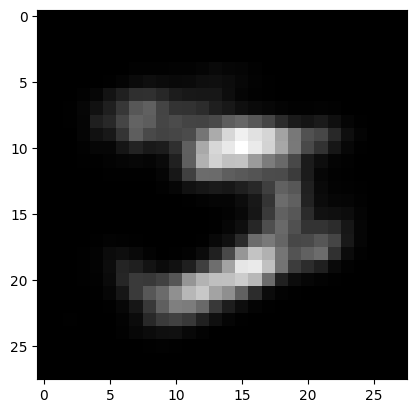

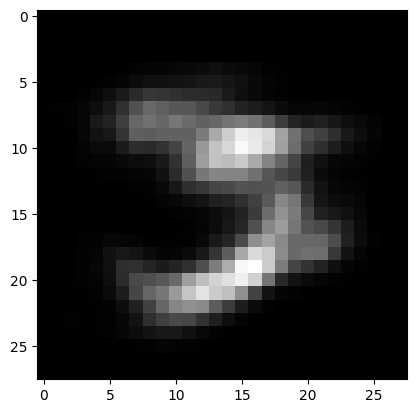

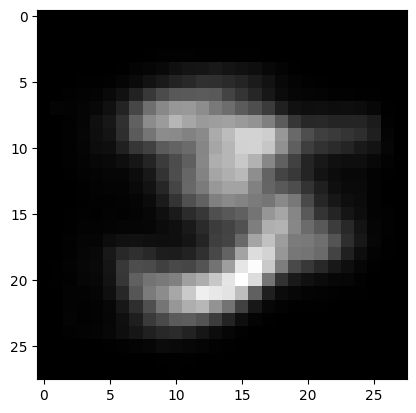

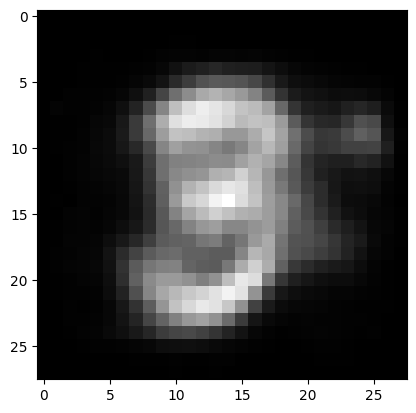

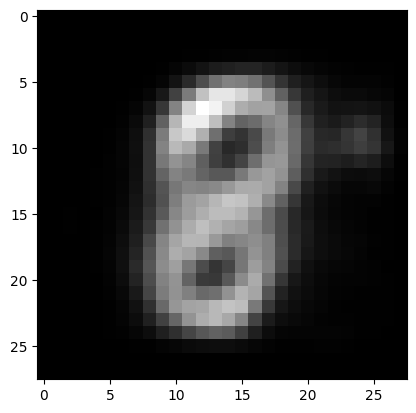

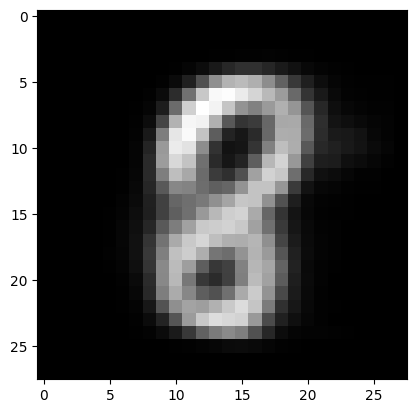

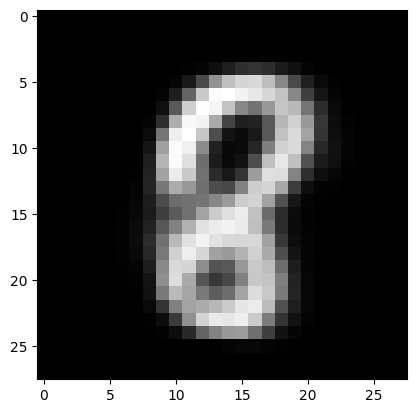

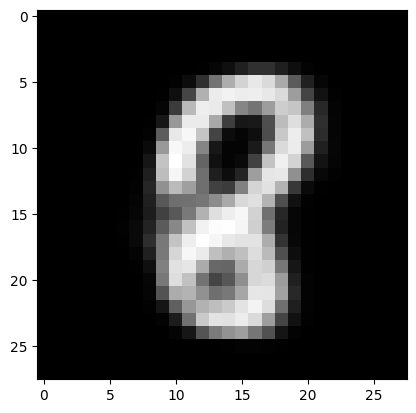

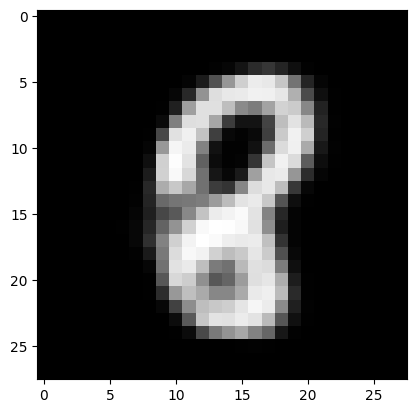

In [16]:
plot_latent_traversal(model, dim_to_vary=1, values_to_use=[-4,-3, -2, -1, 0, 1, 2, 3,4])